## Problem Set 11

### Juan Martin Morelli (NYU Stern)

Let $x_{t}$ be investment. Then the problem can be rewritten as:
\begin{equation}
\max_{x_{t}}E_{0}\sum_{t=0}^{\infty}\beta^{t}U\left(\psi _{t}f(x_{t-1})-x_{t}\right)
\end{equation}


This yields the Euler Equation:
\begin{equation}
U'(\psi_{t}f(x_{t-1})-x_{t})=\beta f'(x_{t})E_{t}\psi_{t+1}U'(\psi_{t+1}f(x_{t})-x_{t+1})
\end{equation}


We assume that the shock is distrubited lognormal with mean -0.1 and variance 0.2. We can write the sequential problem in the following recursive form:

\begin{equation}
V(y_{t}) =\max_{c_{t}} U\left(c_{t}\right) + \beta E_{t}V(\psi_{t+1}f(y_{t}-c_{t}))
\end{equation}


In what follows I first define the type and the the required functions. I needed to parallelize the code since it took a long time (average 150 seconds) per $\beta$. Perhaps my code is inefficient in some way.

In [60]:
using QuantEcon
using Interpolations
using Optim
using PyPlot
using CompEcon:golden_method
using Distributions


addprocs(8)

@everywhere begin

    using QuantEcon
    using Interpolations
    using Optim
    using CompEcon:golden_method
    using Distributions
    
    type model
        a::Float64 # Parameter Logistic Function
        b::Float64 # Parameter Logistic Function
        c::Float64 # Parameter Logistic Function
        d::Float64 # Parameter Logistic Function
        θ::Float64 # Parameter Utility Function
        γ::Float64 # Parameter Utility Function 
        α::Float64 # Parameter Production Function
        β::Float64 # Discount Factor
        μ::Float64 # Mean Lognormal Shock
        σ::Float64 # Standard Deviation Lognormal Shock
        tol::Float64
        maxit::Int64
        num_y::Int64
        grid_y::Array{Float64,1}
        num_N::Int64 # Total number of draws from the lognormal
        lnorm
        sample::Array{Float64} # Sample vector from lognormal distribution
    end
    
    u(md::model,x)  = 1-exp(-md.θ*x^(md.γ))
    f(md::model,x)  = x^md.α*lf(md,x)
    lf(md::model,x) = md.a + (md.b-md.a)/(1+exp(-md.c*(x-md.d)))
    
    
    function interp(md::model,cons,y_val,ψ,V_vals)
        yp = ψ*f(md,y_val-cons)
        knots = (collect(md.grid_y),)
        itp = interpolate(knots, vec(V_vals), Gridded(Linear()))
        itp2 = extrapolate(itp, Flat())
        V_interp = itp2[yp]
    end
    
    
    function RHS(md::model,cons,y_val,V_vals)
        V_interp = Array(Float64,md.num_N,1)
        for (i_ψ,ψ_val) in enumerate(md.sample)
            V_interp[i_ψ,1] = interp(md,cons,y_val,ψ_val,V_vals)
        end
        EV = mean(V_interp[:,1])

        rhs = u(md,cons) + md.β*EV

        return rhs
    end
    
    
    function one_step(md::model,V0)
        c_opt = SharedArray(Float64,md.num_y,1)
        V_max = SharedArray(Float64,md.num_y,1)
    
        @sync @parallel for y_i in eachindex(md.grid_y)
            y_val = md.grid_y[y_i]
            RHS_c(cons) = RHS(md,cons,y_val,V0)
            c_opt[y_i],V_max[y_i] = golden_method(RHS_c,0.0,y_val-0.0001)
        end
    
        return V_max,c_opt
    end
    
end

Next I define hte Howard Iteration Step function and the iteration function.

In [61]:
function HIS_onestep(md::model,c_opt,V_init)
    Vh1 = Array(Float64,md.num_y,1)
    
    for (i_y,y_val) in enumerate(md.grid_y)
        Vh1[i_y] = RHS(md,c_opt[i_y],y_val,V_init)
    end
    
    return Vh1
end

HIS_onestep (generic function with 1 method)

In [62]:
function iter(md::model)
    dist = 1.0
    
    V0 = zeros(md.num_y)
    
    iteration = 0
    
    while dist>md.tol
        iteration+=1
        if iteration>md.maxit
            break
        end
        
        # Howard Improvement Step
        if iteration>=2
            c_opt = one_step(md,V0)[2]
            
            iter_h = 0
            dif_h  = 1
            Vh0 = copy(V0)
            
            while dif_h>=md.tol
                iter_h+=1
                if iter_h>2000
                    break
                end
                Vh1 = HIS_onestep(md,c_opt,Vh0)
                dif_h = norm(Vh1-Vh0)
                Vh0 = copy(Vh1)
            end
            
            V1 = copy(Vh0)
            
        else
            V1 = one_step(md,V0)[1]
        end
        
        dist = norm(V1-V0)
        
        
        V0 = copy(V1)
    end    
    
    c_opt = one_step(md,V0)[2]
    
    return V0, c_opt
end

iter (generic function with 1 method)

Finally I give values to the model and compute for a given $\beta$. Then I plot for that $\beta=0.945$.

In [63]:
function model(;a=1.0,
                b=2.0,
                c=20.0,
                d=1.0,
                θ=0.5,
                γ=0.9,
                α=0.5,
                β=0.945,
                μ=-0.1,
                σ=0.2,
                tol=0.00001,
                maxit=1000,
                num_y=60,
                num_N=800)

    grid_y1 = collect(linspace(0.1,1.0,num_y/4))
    grid_y2 = collect(linspace(1.05,2.9,num_y/2))
    grid_y3 = collect(linspace(3.0,8.0,num_y/4))
    
    grid_y = [grid_y1;grid_y2;grid_y3]
    
    
    lnorm = LogNormal(μ, σ)
    sample = rand(lnorm, num_N)
    
    model(a,b,c,d,θ,γ,α,β,μ,σ,tol,maxit,num_y,grid_y,num_N,lnorm,sample)
end


model

113.612739 seconds (799.38 M allocations: 48.270 GB, 7.38% gc time)


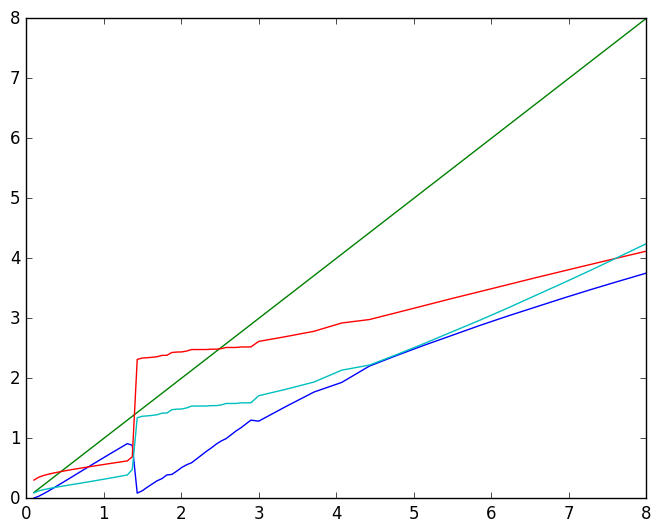

4-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x31e9d0510>
 PyObject <matplotlib.lines.Line2D object at 0x32615d2d0>
 PyObject <matplotlib.lines.Line2D object at 0x32618f190>
 PyObject <matplotlib.lines.Line2D object at 0x31e7ba690>

In [64]:

md = model()
@time V_opt,C_opt = iter(md)

x_opt = md.grid_y - C_opt
fv = Array(Float64,md.num_y,1)
for (i_x,xval) in enumerate(x_opt)
    fv[i_x] = f(md,xval)
end
    

plot(md.grid_y,[C_opt md.grid_y fv x_opt])

As we can see, there are kinks around $y=1.3$. The blue lines is consumption, the red line is production and the skyblue one is investment.

Next I solve for several values of $\beta$, as to replicate figure 1. However, first I will show the value function and the consumption policy function for different values of $\beta$.

In [ ]:

Ny = 60
num_bet = 6

beta_vec = collect(linspace(0.945,0.99,num_bet))

V_opt_vec = Array(Float64,Ny,num_bet)
C_opt_vec = Array(Float64,Ny,num_bet)

for (i_b,b_val) in enumerate(beta_vec)
    print(b_val)
    md = model(β=b_val)
    @time V_opt,C_opt = iter(md)
    
    V_opt_vec[:,i_b] = V_opt
    C_opt_vec[:,i_b] = C_opt
end

In [ ]:
using JLD
save("/Users/jmorelli/comp_econ/quantecon_nyu_2016_homework/hw_set_11/myfile.jld", "C_pol", C_opt_vec, "V_fun", V_opt_vec)

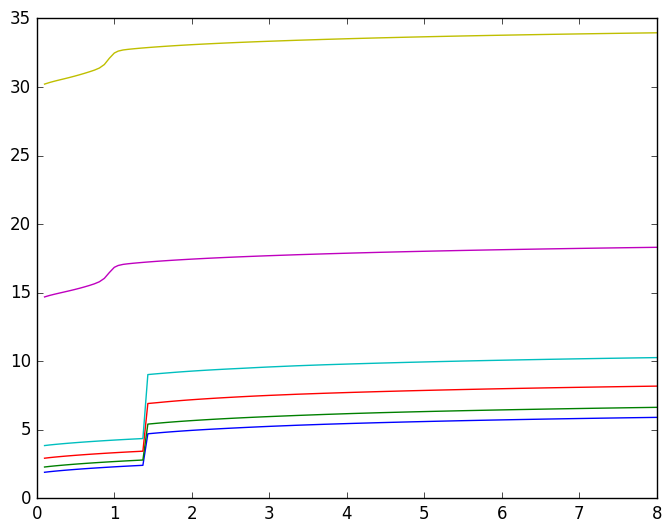

6-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x3269b4dd0>
 PyObject <matplotlib.lines.Line2D object at 0x31e9d4cd0>
 PyObject <matplotlib.lines.Line2D object at 0x31e9d4ed0>
 PyObject <matplotlib.lines.Line2D object at 0x326b86890>
 PyObject <matplotlib.lines.Line2D object at 0x326b869d0>
 PyObject <matplotlib.lines.Line2D object at 0x326b86ad0>

In [65]:
V_opt_vec = load("/Users/jmorelli/comp_econ/quantecon_nyu_2016_homework/hw_set_11/myfile.jld", "V_fun")
C_opt_vec = load("/Users/jmorelli/comp_econ/quantecon_nyu_2016_homework/hw_set_11/myfile.jld", "C_pol")
md = model()
plot(md.grid_y,V_opt_vec)

As expected, the value functions are increasing in $y$. They are also increasing in $\beta$, due to the effect it has on investment. Note that for low values of $\beta$ we can see the kink, but it is attenuated for higher values of $\beta$.

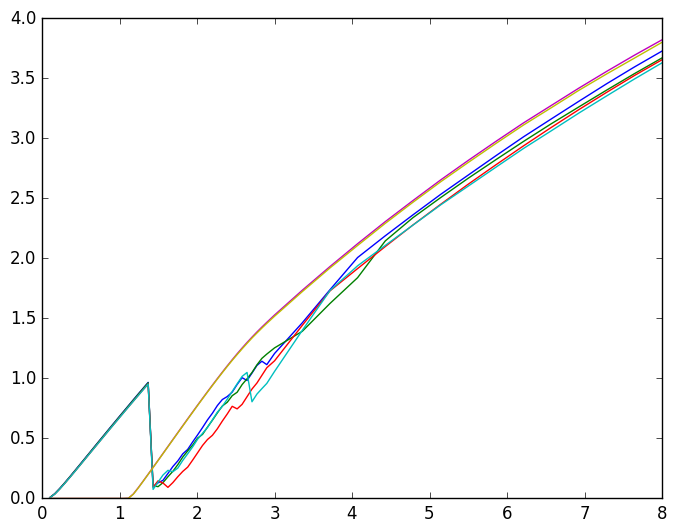

6-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x3263a1bd0>
 PyObject <matplotlib.lines.Line2D object at 0x3275ff290>
 PyObject <matplotlib.lines.Line2D object at 0x327607750>
 PyObject <matplotlib.lines.Line2D object at 0x326411690>
 PyObject <matplotlib.lines.Line2D object at 0x3264117d0>
 PyObject <matplotlib.lines.Line2D object at 0x3264118d0>

In [66]:
plot(md.grid_y,C_opt_vec)

From this pot we get that there is still a kink for high values of $\beta$, but it not of the same "double-knife" shape. In particular, for high $\beta$ the agent will find optimal to save all the resources and invest instead of consume, when the income is low enough.

We can also see that for income large enough, the policy function is concave.

In the next sections I will simulate for N=5000 agents and T=100 periods. Then I take $Y_{t=100}$ and compute the kernel density. This should give me the stationary distribution of $\log{y}$.

Note that I used a finer grid for output, so I interpolate the consumption policy.

In [25]:
function interpolate_policy(md::model,C_opt,yval)
        knots = (collect(md.grid_y),)
        itp = interpolate(knots, vec(C_opt), Gridded(Linear()))
#         itp2 = extrapolate(itp, Flat())
        C_interp = itp[yval]
end

function density_y(md::model,yval,yval_prime,cons)
    eps_val  = yval_prime/f(md,yval-cons)
    prob = pdf(md.lnorm,eps_val)/f(md,yval-cons)

    return prob
end

function simul(md::model,sample_eps,C_opt,initial_y,T,grid_y_finer)
        y_vals = Array(Float64,T,1)
        c_vals = Array(Float64,T,1)
        x_vals = Array(Float64,T,1)

        y0 = grid_y_finer[initial_y]
        y_vals[1] = y0
        c_vals[1] = interpolate_policy(md,C_opt,y0)
        x_vals[1] = y0 - c_vals[1]

        for t=2:T
            y_vals[t] = sample_eps[t]*f(md,x_vals[t-1])
            c_vals[t] = interpolate_policy(md,C_opt,y_vals[t])
            x_vals[t] = y_vals[t] - c_vals[t]
        end

        return y_vals,c_vals,x_vals
end


function get_py(md::model,C_opt,initial_y,grid_y_finer)
    py_out = Array(Float64,length(grid_y_finer),1)
    y_sim_end = Array(Float64,N_sim)

    for i_n=1:N_sim
        sample_eps = rand(md.lnorm,T_sim)
        y_out = simul(md,sample_eps,C_opt,initial_y[i_n],T_sim,grid_y_finer)[1]
        y_sim_end[i_n] = y_out[end]
    end

    for (i_y,y_v) in enumerate(grid_y_finer)
        cons = interpolate_policy(md,C_opt,y_v)
        prob = Array(Float64,N_sim,1)

        for (y_p_i,y_p_v) in enumerate(y_sim_end)
            prob[y_p_i] = density_y(md,y_v,y_p_v,cons)
        end

        py_out[i_y] = mean(prob)
    end

    return py_out,y_sim_end
end

get_py (generic function with 1 method)

In [53]:
md1 = model()
N_sim = 5000
T_sim = 100
initial_y_vals = rand(md1.lnorm, N_sim)

N_finer=500

grid_y_finer = collect(linspace(0,8,N_finer))

initial_y = Array(Int64,N_sim,1)
for ii=1:N_sim
    initial_y[ii] = findfirst(grid_y_finer.>initial_y_vals[ii])
end

py   = Array(Float64,N_finer,num_bet)
y_50 = Array(Float64,N_sim,num_bet);

In [54]:
for (i_b,b_val) in enumerate(beta_vec)
    md = model(β=b_val)   
    C_opt =  C_opt_vec[:,i_b]
    y_50[:,i_b] = get_py(md,C_opt,initial_y,grid_y_finer)[2]
    py[:,i_b] = get_py(md,C_opt,initial_y,grid_y_finer)[1]
    
end


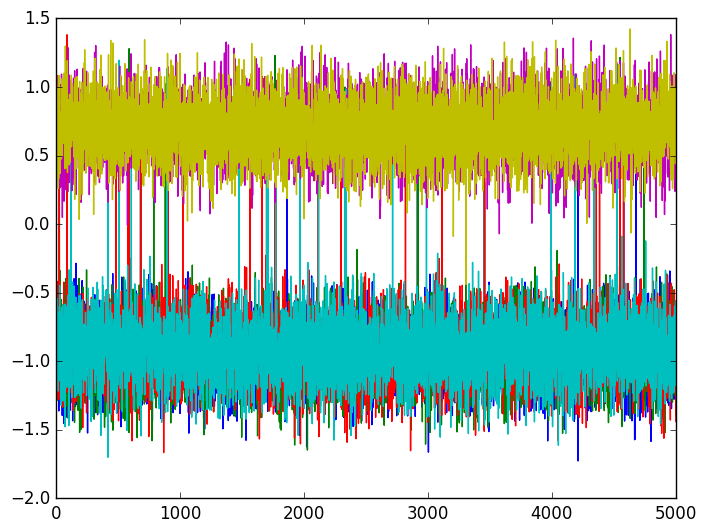

6-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x324723190>
 PyObject <matplotlib.lines.Line2D object at 0x323a64810>
 PyObject <matplotlib.lines.Line2D object at 0x323a1a690>
 PyObject <matplotlib.lines.Line2D object at 0x324753c10>
 PyObject <matplotlib.lines.Line2D object at 0x324753d50>
 PyObject <matplotlib.lines.Line2D object at 0x324753e50>

In [55]:
md = model()
plot(log(y_50))

The previous figure shows the 5000 simulations for each $\beta$. It is clear that there are going to be two distinct distributions, one for high $\beta$'s and another one for lower ones. This can be seen in the kernels below, which tries to replicate Figure 1 from the paper.


Even though I put it in the code, I did not use the one-step ahead estimator for the invariant distribution since it did not give me nice results. I probably need more precision, but the simulations were instructive enough to see the desired effect. In particular, the figure below shows the shift in the distributions for low vs high levels of $\beta$.

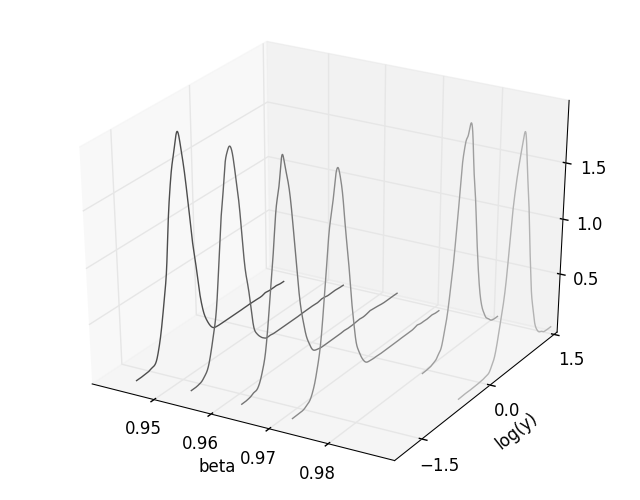

3-element Array{Any,1}:
 PyObject <matplotlib.axis.XTick object at 0x3264ce910>
 PyObject <matplotlib.axis.XTick object at 0x326472c90>
 PyObject <matplotlib.axis.XTick object at 0x323698150>

In [67]:
nmax = num_bet
ns = 1:nmax

fig = figure()
ax = fig[:gca](projection="3d")

a, b = -2.0, 1.5
gs = 100
xs = linspace(a, b, gs)

# == Build verts == #
greys = linspace(0.3, 0.7, nmax)
verts = []
for n=1:nmax
    kde_est = kde(log(y_50[:,n]))
    _xs, ys = kde_est.x, kde_est.density
    ax[:plot3D](_xs, ys, beta_vec[n], zdir="x", color=string(greys[n]), fillstyle="bottom")
end

ax[:set_xlim3d](0.94, 0.99)
ax[:set_xticks]((0.95,0.96,0.97,0.98))
ax[:set_xlabel]("beta")
ax[:set_yticks]((-1.5, 0, 1.5))
ax[:set_ylim3d](a, b)
ax[:set_ylabel]("log(y)")
ax[:set_zlim3d](0, 2.0)
ax[:set_zticks]((0.5, 1.0, 1.5))